In [3]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')

import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
import pickle
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_predict
import scipy
def uniform_distribution(lo, hi):
    return scipy.stats.uniform(lo, hi - lo)
def ProbaScoreProxy(y_true, y_probs, proxied_func, **kwargs):
    return proxied_func(y_true, y_probs, **kwargs)
from sklearn import calibration

# %matplotlib widget



In [2]:
game_df = pd.read_parquet(os.path.join(data_dir, 'game_data.parquet'))
game_df = game_df.sort_values(by='game_date', ascending=False).reset_index(drop=True)

max_away_score = np.max(game_df["away_score"])
max_home_score = np.max(game_df["home_score"])
n_categories = (max_home_score + 1) * (max_away_score + 1)

import time
def get_model_outputs(model, input_data, running_scores):
    start_time = time.time()
    raw_output = model.predict_proba(input_data)
    # Exact score outputs    
    score_probs = np.zeros((input_data.shape[0], n_categories))
    score_probs[:, model.classes_] = raw_output
    # 1X2 prediction & team score outputs
    outcome_probs = np.zeros((input_data.shape[0], 3))
    home_score_probs = np.zeros((input_data.shape[0], max_home_score + 1))
    away_score_probs = np.zeros((input_data.shape[0], max_away_score + 1))
    for home_score in range(max_home_score + 1):
        ft_home_score = home_score + running_scores[:, 0]
        for away_score in range(max_away_score + 1):            
            # print(home_score, "-", away_score)
            ft_away_score = away_score + running_scores[:, 1]
            remaining_prob = score_probs[:, away_score + (max_away_score + 1) * home_score]
            # 1X2 - Home win
            outcome_probs[:, 0] = np.where(ft_home_score > ft_away_score,
                                           outcome_probs[:, 0] + remaining_prob,
                                           outcome_probs[:, 0])
            # 1X2 - Draw
            outcome_probs[:, 1] = np.where(ft_home_score == ft_away_score,
                                           outcome_probs[:, 1] + remaining_prob,
                                           outcome_probs[:, 1])
            # 1X2 - Away win
            outcome_probs[:, 2] = np.where(ft_home_score < ft_away_score,
                                           outcome_probs[:, 2] + remaining_prob,
                                           outcome_probs[:, 2])
            # Team scores
            home_score_probs[:, home_score] += remaining_prob
            away_score_probs[:, away_score] += remaining_prob
    return {
        'remaining_score': score_probs,
        'home_score': home_score_probs,
        'away_score': away_score_probs,
        'ft_outcome': outcome_probs
    }

In [3]:
full_df = pd.read_parquet(data_dir + "/full_df.parquet")

In [4]:
score_change_columns = [
    "away_increase_6",
    "away_increase_3",
    "away_increase_2",
    "away_increase_1",
    "no_increase",
    "home_increase_1",
    "home_increase_2",
    "home_increase_3",
    "home_increase_6",
]
input_names = [
    # "prior_home",
    # "prior_away",
    # "vegas_away_prediction",
    # "vegas_home_prediction",
    "cur_spread",
    "cur_over_under",
    "home_team_has_ball",
    # "home_start_score",
    # "away_start_score",
    "current_score_diff", 
    "current_score_total",
    "quarter",
    "overtime",
    "play_start_time",
    "yd_from_goal",
    "from_scrimmage",
    "kick_off",
    "punt",
    "point_after_kick",
    "two_point_attempt",
    "field_goal_attempt",
    "down",
    "ytg",
    "home_timeouts_remaining",
    "away_timeouts_remaining",
]
output_name = 'remaining_exact_score'
group_col = "game_code"

mask_train = (full_df.season_x<=2019)&(full_df.continuation==0)&(full_df[output_name]>=0)
mask_test = (full_df.season_x==2021)&(full_df.continuation==0)&(full_df[output_name]>=0)
mask_val = (full_df.season_x==2020)&(full_df.continuation==0)&(full_df[output_name]>=0)

X_train_rf = full_df.loc[mask_train, input_names + score_change_columns]
y_train_rf = full_df.loc[mask_train, output_name]
groups_train = full_df.loc[mask_train, group_col]
X_test_rf = full_df.loc[mask_test, input_names + score_change_columns]
y_test_rf = full_df.loc[mask_test, output_name]
groups_test = full_df.loc[mask_test, group_col]
X_val_rf = full_df.loc[mask_val, input_names + score_change_columns]
y_val_rf = full_df.loc[mask_val, output_name]
group_val = full_df.loc[mask_val, group_col]


rf = RandomForestClassifier(verbose=100, n_jobs=-1, bootstrap=False, max_depth=6, max_features="auto", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
# rf_grid = {
#     "n_estimators": np.linspace(start=50, stop=500, num=10, dtype=int),
#     "max_features": ["auto", "sqrt"],
#     "max_depth": np.linspace(5, 15, num=11, dtype=int),
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "bootstrap": [True, False],
# }
# search_random_forest = RandomizedSearchCV(rf, rf_grid,cv=cv,random_state=42,n_iter=10,n_jobs=1,verbose=100)
# rf.fit(X_train_rf,y_train_rf)
# pickle.dump(rf, open(os.path.join(root_dir, 'models/random_forest_best_results.p'), 'wb'))
rf = pickle.load(open(os.path.join(root_dir, "models/random_forest_best_results.p"), 'rb'))
os.system('say "done"')


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1

In [4]:
rf = pickle.load(open(os.path.join(root_dir, "models/random_forest_best_results.p"), 'rb'))


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
rf.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 100,
 'warm_start': False}

In [6]:
plot_input_test = full_df[mask_test][input_names+score_change_columns].values
running_score_test = full_df[mask_test][['home_start_score', 'away_start_score']].values
output_values_test = get_model_outputs(rf, plot_input_test, running_score_test)

c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    8.1s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    9.1s
[Para

In [45]:
print("remaining_score")
remaining_score_output_test = pd.DataFrame(
    output_values_test["remaining_score"],
    columns=[
        "remaining_exact_score_%.f" % int(number)
        for number in range(len(output_values_test["remaining_score"][0]))
    ],
)
print("home_score")
home_score_output_test = pd.DataFrame(
    output_values_test["home_score"],
    columns=[
        "home_score_%.f" % int(number)
        for number in range(len(output_values_test["home_score"][0]))
    ],
)
print("away_score")
away_score_output_test = pd.DataFrame(
    output_values_test["away_score"],
    columns=[
        "away_score_%.f" % int(number)
        for number in range(len(output_values_test["away_score"][0]))
    ],
)
print("ft_outcome")
ft_outcome_output_test = pd.DataFrame(
    output_values_test["ft_outcome"], columns=["xhome_win", "xdraw", "xaway_win"]
)


remaining_score
home_score
away_score
ft_outcome


In [15]:
full_df

,game_code,game_date_x,season_x,home_team_id_x,away_team_id_x,home_final_score,away_final_score,final_score_diff,home_team_outcome,nevent,...,vegas_home_prediction,away_increase_6,away_increase_3,away_increase_2,away_increase_1,no_increase,home_increase_1,home_increase_2,home_increase_3,home_increase_6
0,819846,2008-09-04,2008,351,363,16,7,9,W,1,...,23.0,0.006156,0.001711,0.001613,0.001614,0.982350,0.001614,0.001614,0.001614,0.001714
1,819846,2008-09-04,2008,351,363,16,7,9,W,2,...,23.0,0.001694,0.001616,0.001616,0.001616,0.982075,0.001616,0.001616,0.001718,0.006434
2,819846,2008-09-04,2008,351,363,16,7,9,W,3,...,23.0,0.001721,0.001624,0.001624,0.001624,0.980411,0.001625,0.001624,0.001939,0.007807
3,819846,2008-09-04,2008,351,363,16,7,9,W,4,...,23.0,0.001721,0.001624,0.001624,0.001624,0.980411,0.001625,0.001624,0.001939,0.007807
4,819846,2008-09-04,2008,351,363,16,7,9,W,5,...,23.0,0.001721,0.001624,0.001624,0.001624,0.980411,0.001625,0.001624,0.001939,0.007807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816791,2411004,2021-12-21,2021,343,361,20,10,10,W,193,...,27.0,0.001736,0.001625,0.001625,0.001624,0.982368,0.001668,0.001625,0.001643,0.006087
816792,2411004,2021-12-21,2021,343,361,20,10,10,W,194,...,27.0,0.001739,0.001628,0.001628,0.001627,0.982571,0.001671,0.001627,0.001646,0.005864
816793,2411004,2021-12-21,2021,343,361,20,10,10,W,195,...,27.0,0.001738,0.001626,0.001626,0.001626,0.981104,0.001670,0.001627,0.001667,0.007315
816794,2411004,2021-12-21,2021,343,361,20,10,10,W,196,...,27.0,0.001734,0.001623,0.001623,0.001623,0.981214,0.001666,0.001623,0.001663,0.007232


In [46]:
remaining_score_output_test.to_parquet(os.path.join(data_dir, 'remaining_score_output_test.parquet'))
home_score_output_test.to_parquet(os.path.join(data_dir, 'home_score_output_test.parquet'))
away_score_output_test.to_parquet(os.path.join(data_dir, 'away_score_output_test.parquet'))
ft_outcome_output_test.to_parquet(os.path.join(data_dir, 'ft_outcome_output_test.parquet'))

In [79]:
current_time = time.time()
rf.n_jobs = -1
rf.verbose = 10
full_dict = {}
batch_size = 50000
for batch in range(round(len(full_df) / batch_size)+1):
    start_index = batch*batch_size
    end_index = batch*batch_size+batch_size
    plot_input = full_df[input_names+score_change_columns][start_index:end_index].values
    running_score = full_df[['home_start_score', 'away_start_score']][start_index:end_index].values
    full_dict["batch_" + str(start_index) + "_" + str(end_index)] =get_model_outputs(rf, plot_input, running_score)
    print(start_index, f"{time.time() - current_time:.1f}")
    

c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   38.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   45.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.6s
[Parallel(n_job

0 267.9


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   29.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   36.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   50.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   57.7s
[Parallel(n_job

50000 550.8


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   29.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   36.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   42.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   49.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   56.6s
[Parallel(n_job

100000 841.3


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   10.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   24.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   29.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   42.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   50.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   57.1s
[Parallel(n_job

150000 1130.6


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   10.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   23.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   34.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   40.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   46.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   53.3s
[Parallel(n_job

200000 1399.4


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   22.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   27.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   33.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   39.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   45.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.4s
[Parallel(n_job

250000 1683.6


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   24.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   29.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   36.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   43.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   50.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   58.0s
[Parallel(n_job

300000 1966.1


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   22.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   33.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   39.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   45.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.4s
[Parallel(n_job

350000 2235.9


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   32.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   38.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   45.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.0s
[Parallel(n_job

400000 2520.6


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   24.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   30.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   36.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   43.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   51.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   58.9s
[Parallel(n_job

450000 2801.9


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   32.4s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   44.5s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   51.2s
[Parallel(n_job

500000 3066.8


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   21.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   32.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   38.8s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   46.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.8s
[Parallel(n_job

550000 3340.3


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   21.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   32.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   38.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   44.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   51.5s
[Parallel(n_job

600000 3600.5


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   21.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   26.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   32.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   44.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   51.7s
[Parallel(n_job

650000 3864.3


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   30.7s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   42.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   48.6s
[Parallel(n_job

700000 4120.0


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   22.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   27.7s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   39.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   46.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.6s
[Parallel(n_job

750000 4382.7


In [85]:
current_time = time.time()
for x in full_dict.keys():
    remaining_score_output_test = pd.DataFrame(
        full_dict[x]["remaining_score"],
        columns=[
            "remaining_exact_score_%.f" % int(number)
            for number in range(len(full_dict[x]["remaining_score"][0]))
        ],
    )
    home_score_output_test = pd.DataFrame(
        full_dict[x]["home_score"],
        columns=[
            "home_score_%.f" % int(number)
            for number in range(len(full_dict[x]["home_score"][0]))
        ],
    )
    away_score_output_test = pd.DataFrame(
        full_dict[x]["away_score"],
        columns=[
            "away_score_%.f" % int(number)
            for number in range(len(full_dict[x]["away_score"][0]))
        ],
    )
    ft_outcome_output_test = pd.DataFrame(
        full_dict[x]["ft_outcome"], columns=["xhome_win", "xdraw", "xaway_win"]
    )
    remaining_score_output_test.to_parquet(data_dir + "/remaining_score/" + x + ".parquet")
    home_score_output_test.to_parquet(data_dir + "/home_score/" + x + ".parquet")
    away_score_output_test.to_parquet(data_dir + "/away_score/" + x + ".parquet")
    ft_outcome_output_test.to_parquet(data_dir + "/ft_outcome/" + x + ".parquet")
    print(x, f"{time.time() - current_time:.1f}")



batch_0_50000 154.5
batch_50000_100000 245.0
batch_100000_150000 503.7
batch_150000_200000 670.8
batch_200000_250000 845.3
batch_250000_300000 1057.7
batch_300000_350000 1232.8
batch_350000_400000 1412.8
batch_400000_450000 1590.3
batch_450000_500000 1691.1
batch_500000_550000 1850.5
batch_550000_600000 1994.5
batch_600000_650000 2117.1
batch_650000_700000 2288.4
batch_700000_750000 2441.8
batch_750000_800000 2610.4


In [99]:
full_dict.keys()

dict_keys(['batch_0_50000', 'batch_50000_100000', 'batch_100000_150000', 'batch_150000_200000', 'batch_200000_250000', 'batch_250000_300000', 'batch_300000_350000', 'batch_350000_400000', 'batch_400000_450000', 'batch_450000_500000', 'batch_500000_550000', 'batch_550000_600000', 'batch_600000_650000', 'batch_650000_700000', 'batch_700000_750000', 'batch_750000_800000', 'batch_800000_816796'])

In [ ]:
start_index = batch*batch_size
end_index = batch*batch_size+batch_size
plot_input = full_df[input_names+score_change_columns][start_index:end_index].values
running_score = full_df[['home_start_score', 'away_start_score']][start_index:end_index].values
full_dict["batch_" + str(start_index) + "_" + str(end_index)] =get_model_outputs(rf, plot_input, running_score)
print(start_index, f"{time.time() - current_time:.1f}")


In [98]:
start_index = 800000
end_index = len(full_df)
plot_input = full_df[input_names+score_change_columns][start_index:end_index].values
running_score = full_df[['home_start_score', 'away_start_score']][start_index:end_index].values
full_dict["batch_" + str(start_index) + "_" + str(end_index)] =get_model_outputs(rf, plot_input, running_score)
print(start_index, f"{time.time() - current_time:.1f}")


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   29.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   29.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   33.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   40.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   43.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   46.0s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   49.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   52.3s
[Parallel(n_job

800000 4957.5


In [100]:
current_time = time.time()
for x in ["batch_800000_816796"]:
    remaining_score_output_test = pd.DataFrame(
        full_dict[x]["remaining_score"],
        columns=[
            "remaining_exact_score_%.f" % int(number)
            for number in range(len(full_dict[x]["remaining_score"][0]))
        ],
    )
    home_score_output_test = pd.DataFrame(
        full_dict[x]["home_score"],
        columns=[
            "home_score_%.f" % int(number)
            for number in range(len(full_dict[x]["home_score"][0]))
        ],
    )
    away_score_output_test = pd.DataFrame(
        full_dict[x]["away_score"],
        columns=[
            "away_score_%.f" % int(number)
            for number in range(len(full_dict[x]["away_score"][0]))
        ],
    )
    ft_outcome_output_test = pd.DataFrame(
        full_dict[x]["ft_outcome"], columns=["xhome_win", "xdraw", "xaway_win"]
    )
    remaining_score_output_test.to_parquet(data_dir + "/remaining_score/" + x + ".parquet")
    home_score_output_test.to_parquet(data_dir + "/home_score/" + x + ".parquet")
    away_score_output_test.to_parquet(data_dir + "/away_score/" + x + ".parquet")
    ft_outcome_output_test.to_parquet(data_dir + "/ft_outcome/" + x + ".parquet")
    print(x, f"{time.time() - current_time:.1f}")



batch_800000_816796 18.2


In [28]:
ft_outcomes = pd.DataFrame()

for x in full_dict.keys():
    ft_outcomes = pd.concat([ft_outcomes, pd.read_parquet(data_dir + "/ft_outcome/" + x + ".parquet")])
    print(x, len(ft_outcomes))
ft_outcomes = ft_outcomes.reset_index()


NameError: name 'full_dict' is not defined

In [34]:
ft_outcomes = pd.DataFrame()
batch_size = 50000
for batch in range(round(len(full_df) / batch_size)):
    start_index = batch*batch_size
    end_index = batch*batch_size+batch_size
    # x = batch_500000_550000 
    x = "batch_" + str(start_index) + "_"+ str(end_index)
    print(x)
    ft_outcomes = pd.concat([ft_outcomes, pd.read_parquet(data_dir + "/ft_outcome/" + x + ".parquet")])
ft_outcomes = pd.concat([ft_outcomes, pd.read_parquet(data_dir + "/ft_outcome/batch_800000_816796.parquet")])
ft_outcomes = ft_outcomes.reset_index(drop=True)

batch_0_50000
batch_50000_100000
batch_100000_150000
batch_150000_200000
batch_200000_250000
batch_250000_300000
batch_300000_350000
batch_350000_400000
batch_400000_450000
batch_450000_500000
batch_500000_550000
batch_550000_600000
batch_600000_650000
batch_650000_700000
batch_700000_750000
batch_750000_800000


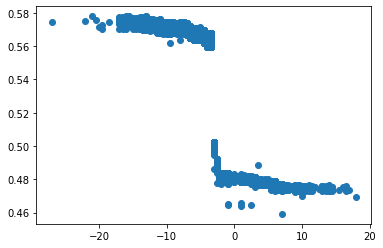

In [107]:

plt.scatter(full_df_lwp[full_df_lwp["nevent"]==1]["cur_spread"], full_df_lwp[full_df_lwp["nevent"]==1]["xhome_win"])


In [38]:
full_df_lwp["home_win"] = np.where(full_df_lwp["home_team_outcome"] == "W", 1, 0)
full_df_lwp["away_win"] = np.where(full_df_lwp["home_team_outcome"] == "L", 1, 0)
full_df_lwp["draw"] = np.where(full_df_lwp["home_team_outcome"] == "T", 1, 0)

In [39]:
mlp = pickle.load(open(os.path.join(root_dir, "models/game_score.sav"), 'rb'))
mlp_input_names = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'play_start_time', 'yd_from_goal', 'down', 'ytg']
plot_input_mlp = full_df[mask_test][mlp_input_names]
running_score_mlp = full_df[mask_test][['home_start_score', 'away_start_score']].values
mlp_outpus = get_model_outputs(mlp, plot_input_mlp, running_score_mlp)


c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [41]:
test_df = full_df_lwp[mask_test]
train_df = full_df_lwp[mask_train]
test_df["naive_home_win"] = np.mean(train_df["xhome_win"])
print(brier_score_loss(test_df["home_win"], test_df["xhome_win"]))
print(brier_score_loss(test_df["home_win"], test_df["naive_home_win"]))
test_df_lwp = test_df.join(pd.DataFrame(mlp_outpus["ft_outcome"], index=test_df.index, columns = ["xhome_win_mlp", "xdraw_mlp", "xaway_win_mlp"]))
print(brier_score_loss(test_df_lwp["home_win"], test_df_lwp["xhome_win_mlp"]))


0.15354508372706954
0.2504292587449898
0.15879751090599556


C:\Users\lucas\AppData\Local\Temp\ipykernel_2436\2058229312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["naive_home_win"] = np.mean(train_df["xhome_win"])


In [49]:
test_df_lwp["time_left_in_game"] = np.where(test_df_lwp["quarter"] <= 4, test_df_lwp["play_start_time"] + (4 - test_df_lwp["quarter"]) * 900, test_df_lwp["play_start_time"])
test_df_lwp["time_elapsed"] = 900 - test_df_lwp["play_start_time"] + (test_df_lwp["quarter"] - 1) * 900
test_df_lwp["minute_bucket"] = round((3600 - test_df_lwp["time_left_in_game"])/60)
test_df_lwp["rf_error"]  = (test_df_lwp["home_win"] - test_df_lwp["xhome_win"])**2
test_df_lwp["mlp_error"]  = (test_df_lwp["home_win"] - test_df_lwp["xhome_win_mlp"])**2
test_df_lwp

,game_code,game_date_x,season_x,home_team_id_x,away_team_id_x,home_final_score,away_final_score,final_score_diff,home_team_outcome,nevent,...,draw,naive_home_win,xhome_win_mlp,xdraw_mlp,xaway_win_mlp,time_left_in_game,time_elapsed,minute_bucket,rf_error,mlp_error
756218,2337429,2021-09-09,2021,362,331,31,29,2,W,1,...,0,0.538448,0.621807,0.025002,0.353190,3600.0,0.0,0.0,0.185632,0.143030
756220,2337429,2021-09-09,2021,362,331,31,29,2,W,3,...,0,0.538448,0.646545,0.023812,0.329643,3600.0,0.0,0.0,0.167328,0.124930
756221,2337429,2021-09-09,2021,362,331,31,29,2,W,4,...,0,0.538448,0.645999,0.023839,0.330161,3557.0,43.0,1.0,0.167328,0.125316
756222,2337429,2021-09-09,2021,362,331,31,29,2,W,5,...,0,0.538448,0.644942,0.023892,0.331165,3513.0,87.0,1.0,0.167328,0.126066
756223,2337429,2021-09-09,2021,362,331,31,29,2,W,6,...,0,0.538448,0.645220,0.023878,0.330902,3506.0,94.0,2.0,0.183353,0.125869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816789,2411004,2021-12-21,2021,343,361,20,10,10,W,191,...,0,0.538448,0.992389,0.002191,0.005419,54.0,3546.0,59.0,0.001660,0.000058
816790,2411004,2021-12-21,2021,343,361,20,10,10,W,192,...,0,0.538448,0.992389,0.002191,0.005419,54.0,3546.0,59.0,0.001977,0.000058
816793,2411004,2021-12-21,2021,343,361,20,10,10,W,195,...,0,0.538448,0.995770,0.001232,0.002998,45.0,3555.0,59.0,0.001585,0.000018
816794,2411004,2021-12-21,2021,343,361,20,10,10,W,196,...,0,0.538448,0.996538,0.001000,0.002462,29.0,3571.0,60.0,0.001603,0.000012


(0.0, 0.3)

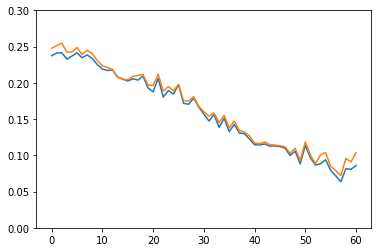

In [52]:
plot_input_by_minute_base = test_df_lwp.groupby("minute_bucket", as_index=False).mean()#[["minute_bucket", "naive_error", "base_error"]]
plt.plot(plot_input_by_minute_base["minute_bucket"], plot_input_by_minute_base["rf_error"])
plt.plot(plot_input_by_minute_base["minute_bucket"], plot_input_by_minute_base["mlp_error"])
plt.ylim([0, 0.3])


In [ ]:
brier_score_loss(test_df["away_win"], test_df["xaway_win"])

In [60]:
full_df[(full_df["quarter"]==4)&(full_df["play_start_time"]==0)][["current_score_diff", "nevent"]].groupby("current_score_diff", ).count()

,nevent
current_score_diff,
-49,1
-45,2
-43,1
-40,1
-39,1
...,...
48,1
52,1
55,1


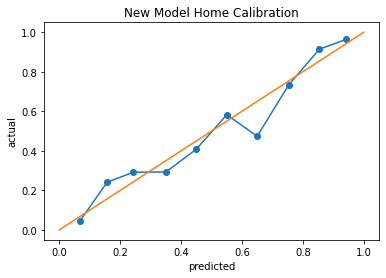

In [171]:
calb_df = test_df_lwp[test_df_lwp["quarter"]==2]
calb = calibration.calibration_curve(calb_df["home_win"], calb_df["xhome_win"], n_bins=10)
plt.plot(calb[1], calb[0], marker = "o")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("New Model Home Calibration")
plt.plot([0, 1], [0, 1])

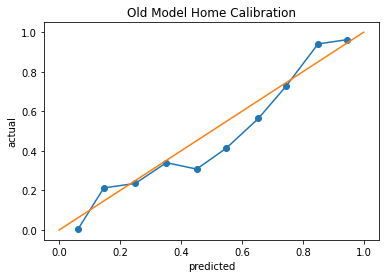

In [172]:
calb_df = test_df_lwp[test_df_lwp["quarter"]==2]
calb = calibration.calibration_curve(calb_df["home_win"], calb_df["xhome_win_mlp"], n_bins=10)
plt.plot(calb[1], calb[0], marker = "o")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Old Model Home Calibration")

plt.plot([0, 1], [0, 1])

NameError: name 'full_df_lwp' is not defined

In [10]:
brier_scorer = make_scorer(
    ProbaScoreProxy,
    greater_is_better=False,  # True
    needs_proba=True,
    proxied_func=brier_score_loss,
)
output_name_score_change = "mov_change"
mask_train = (full_df.season_x<=2019)&(full_df.continuation==0)&(full_df[output_name]>=0)
mask_test = (full_df.season_x==2021)&(full_df.continuation==0)&(full_df[output_name]>=0)
mask_val = (full_df.season_x==2020)&(full_df.continuation==0)&(full_df[output_name]>=0)
group_col = "game_code"

output_name_game_outcome = "home_team_outcome"
X_all = full_df[input_names+score_change_columns]
y_all_game_outcome = full_df[output_name_game_outcome]
group_all_game_outcome = full_df[group_col]

X_train = full_df.loc[mask_train, input_names+score_change_columns]
y_train_game_outcome = full_df.loc[mask_train, output_name_game_outcome]
groups_train = full_df.loc[mask_train, group_col]
X_test = full_df.loc[mask_test, input_names+score_change_columns]
y_test_game_outcome = full_df.loc[mask_test, output_name_game_outcome]
groups_test = full_df.loc[mask_test, group_col]
X_val = full_df.loc[mask_val, input_names+score_change_columns]
y_val_game_outcome = full_df.loc[mask_val, output_name_game_outcome]
group_val = full_df.loc[mask_val, group_col]

categoricals = [
    'home_team_has_ball',
    'overtime',
    'from_scrimmage',
    'kick_off',
    'punt',
    'point_after_kick',
    'two_point_attempt',
    'field_goal_attempt',
    'down',
    
]
COMPUTE_PARAMS = {"thread_count": -1}
# COMPUTE_PARAMS = {"task_type":"GPU", "devices": "0:1", "bootstrap_type": "Poisson"}
param_spaces={
    "learning_rate": uniform_distribution(0.01, 0.1),
    "max_depth": range(5, 16),
    # "subsample": uniform_distribution(0.9, 1),
    "l2_leaf_reg": uniform_distribution(1, 4),
    "boosting_type": ["Plain"],
    }

import catboost as cb
curr_val_pool_game_outcome =cb.Pool(
        data=X_val,
        label=y_val_game_outcome,
        cat_features=categoricals,
        feature_names=input_names+score_change_columns,
)

CLASSIFIER_PARAMS = {
    # "n_estimators": 10,
    "num_trees": 1000,
    "auto_class_weights": "Balanced",

    # "loss_function": JITRmseObjective(),
    # "eval_metric": JITRmseMetric(),
    **COMPUTE_PARAMS,
}
HPO_PARAMS = {"n_jobs": 1}

cv=GroupKFold(n_splits=3)
FIT_PARAMS = {
    "verbose": 1,
    "early_stopping_rounds": 5,
    "use_best_model": True,
}

clf_game_outcome=cb.CatBoostClassifier(early_stopping_rounds=5,cat_features=categoricals, **CLASSIFIER_PARAMS)

search_game_outcome = RandomizedSearchCV(clf_game_outcome, param_spaces,cv=cv,random_state=1,n_iter=10,n_jobs=1,verbose=100)
# search_game_outcome.fit(X_train,y_train_game_outcome, eval_set=curr_val_pool_game_outcome,groups=groups_train, **FIT_PARAMS)
# pickle.dump(search_game_outcome, open(os.path.join(root_dir, 'models/game_outcome_catboost.p'), 'wb'))
search_game_outcome = pickle.load(open(os.path.join(root_dir, 'models/game_outcome_catboost.p'), 'rb'))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START boosting_type=Plain, l2_leaf_reg=2.251066014107722, learning_rate=0.07482920440979424, max_depth=14


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.0155969	test: 1.0887536	best: 1.0887536 (0)	total: 15.3s	remaining: 4h 14m 12s
1:	learn: 0.9525648	test: 1.0893702	best: 1.0887536 (0)	total: 29.9s	remaining: 4h 8m 40s
2:	learn: 0.9055459	test: 1.0964959	best: 1.0887536 (0)	total: 44.1s	remaining: 4h 4m 10s
3:	learn: 0.8534809	test: 1.1016086	best: 1.0887536 (0)	total: 57.4s	remaining: 3h 58m 11s
4:	learn: 0.8052008	test: 1.1067662	best: 1.0887536 (0)	total: 1m 10s	remaining: 3h 52m 49s
5:	learn: 0.7713216	test: 1.1216728	best: 1.0887536 (0)	total: 1m 22s	remaining: 3h 48m 19s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 1.088753585
bestIteration = 0

Shrink model to first 1 iterations.
[CV 1/3; 1/10] END boosting_type=Plain, l2_leaf_reg=2.251066014107722, learning_rate=0.07482920440979424, max_depth=14;, score=0.688 total time= 1.5min
[CV 2/3; 1/10] START boosting_type=Plain, l2_leaf_reg=2.251066014107722, learning_rate=0.07482920440979424, max_depth=14
0:	learn: 1.0231880	test: 1.0817482	best: 1.08174

In [14]:
big_cv = GroupKFold(n_splits=5)
final_model_game_outcome = cb.CatBoostClassifier(n_estimators=search_game_outcome.best_estimator_.tree_count_,**search_game_outcome.best_params_,cat_features=categoricals,verbose=1)
predictions_game_outcome = cross_val_predict(final_model_game_outcome,X_all, y_all_game_outcome,groups=group_all_game_outcome,cv=big_cv,verbose=1,n_jobs=1, method="predict_proba")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.0680188	total: 43.2s	remaining: 9m 21s
1:	learn: 1.0399201	total: 1m 31s	remaining: 9m 8s
2:	learn: 1.0134309	total: 2m 12s	remaining: 8m 5s
3:	learn: 0.9885657	total: 2m 52s	remaining: 7m 12s
4:	learn: 0.9653060	total: 3m 32s	remaining: 6m 21s
5:	learn: 0.9433216	total: 4m 11s	remaining: 5m 35s
6:	learn: 0.9223532	total: 4m 53s	remaining: 4m 53s
7:	learn: 0.9028394	total: 5m 37s	remaining: 4m 12s
8:	learn: 0.8842977	total: 6m 16s	remaining: 3m 29s
9:	learn: 0.8665744	total: 6m 58s	remaining: 2m 47s
10:	learn: 0.8498485	total: 7m 33s	remaining: 2m 3s
11:	learn: 0.8338821	total: 8m 7s	remaining: 1m 21s
12:	learn: 0.8187707	total: 8m 41s	remaining: 40.1s
13:	learn: 0.8038296	total: 9m 17s	remaining: 0us
0:	learn: 1.0684886	total: 36.1s	remaining: 7m 49s
1:	learn: 1.0401503	total: 1m 11s	remaining: 7m 10s
2:	learn: 1.0137531	total: 1m 44s	remaining: 6m 23s
3:	learn: 0.9893384	total: 2m 16s	remaining: 5m 41s
4:	learn: 0.9663570	total: 2m 48s	remaining: 5m 3s
5:	learn: 0.9446104

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 42.8min finished


In [20]:
pd.DataFrame(search_game_outcome.best_estimator_.feature_importances_, index=search_game_outcome.best_estimator_.feature_names_)

,0
cur_spread,27.691050
cur_over_under,28.052041
home_team_has_ball,0.207517
current_score_diff,24.556147
current_score_total,3.502965
quarter,2.378567
overtime,0.176454
play_start_time,0.316017
yd_from_goal,0.585248
from_scrimmage,0.000000
